/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


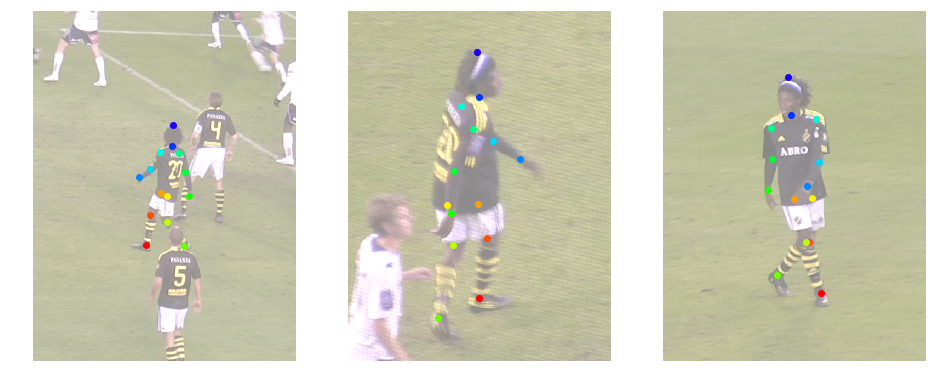

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
import numpy as np
import cv2
from cselect import color as cs
from time import time
import mvpose.data.kth_football2 as kth

colors = cs.lincolor(20).astype('float32')/255
FRAME = 0
data_root = Settings['data_root']
seq1_zipname = 'player1sequence2.zip'
seq1_dir = 'Sequence 2'
Im, Calib, pos2d, pos3d = kth.get(data_root, seq1_zipname, seq1_dir, FRAME)

fig = plt.figure(figsize=(16,8))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3,cid+1); ax.axis('off')
    ax.imshow(im, alpha=0.5)
    joints = pos2d[:,:,cid]
    for jid, (x,y) in enumerate(joints):
        ax.scatter(x,y,color=colors[jid])

plt.show()

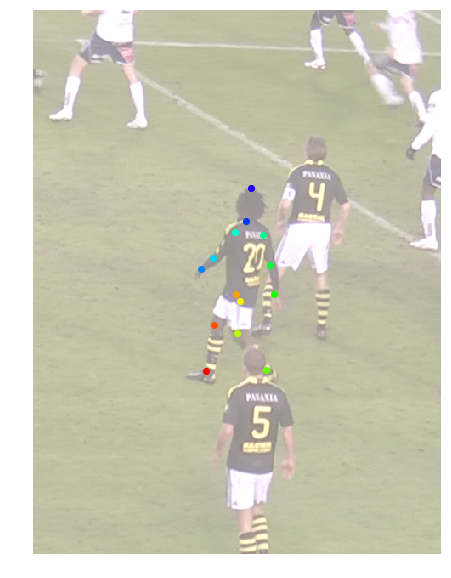

In [2]:
CID = 0
colors = cs.lincolor(20).astype('float32')/255

im = Im[CID]
cam = Calib[CID]

fig = plt.figure(figsize=(8, 10))
ax = fig.add_subplot(111); ax.axis('off')
ax.imshow(im, alpha=0.5)
projected2d = cam.projectPoints(pos3d)
for jid, (x,y) in enumerate(projected2d):
    ax.scatter(x, y, color=colors[jid])

plt.show()

In [3]:
from mvpose import pose
from mvpose.algorithm import graphcut
import paf_loader
from mvpose.data.default_limbs import DEFAULT_SENSIBLE_LIMB_LENGTH


heatmaps, pafs = paf_loader.load_confidence_map_and_paf(
    'kth' + seq1_zipname[0:-4], Im, FRAME)

_start = time()
graphcut_params = graphcut.get_parameters(
    radius=0.05, max_radius=0.3)
Debug, detections = pose.estimate(Calib, heatmaps, pafs,
                      sensible_limb_length=DEFAULT_SENSIBLE_LIMB_LENGTH/1000,
                      graphcut_params=graphcut_params, debug=True)
_end = time()

print('found detections:', len(detections))

elapsed: 54.37638735771179
elapsed: 57.112417221069336
elapsed: 57.04195499420166
step 1: elapsed 0.9423060417175293
step 2: elapsed 0.019625425338745117
step 3: elapsed 0.35475635528564453
-------------------------------------------
Handle transitivity:
	Intra:		 16
	Intra(choice):	 0
	Inter:		 144
	Inter(choice):	 5
-------------------------------------------
	Time =  112  ms
	result: 0

	Total cost: 188.6004785562043

# valid points:		 32
# invalid points:	 3
step 4: elapsed 0.11592650413513184
step 5: elapsed 0.001970052719116211
found detections: 1


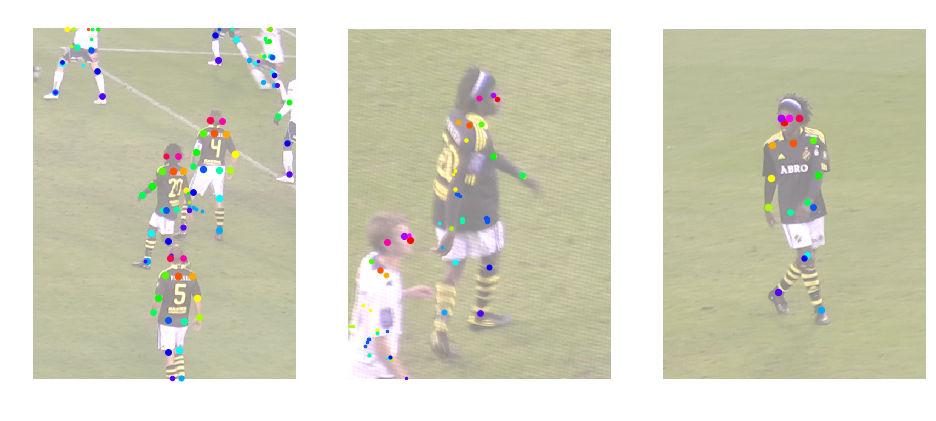

In [4]:
colors = cs.lincolor(19)/255
fig = plt.figure(figsize=(16,12))
for cid, im in enumerate(Im):
    ax = fig.add_subplot(1,3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    
    for jid in range(Debug.candidates2d.n_joints):
        for x,y,score in Debug.candidates2d.peaks2d_undistorted[cid][jid]:
            ax.scatter(x,y,s=score*50, c=colors[jid])
plt.show()

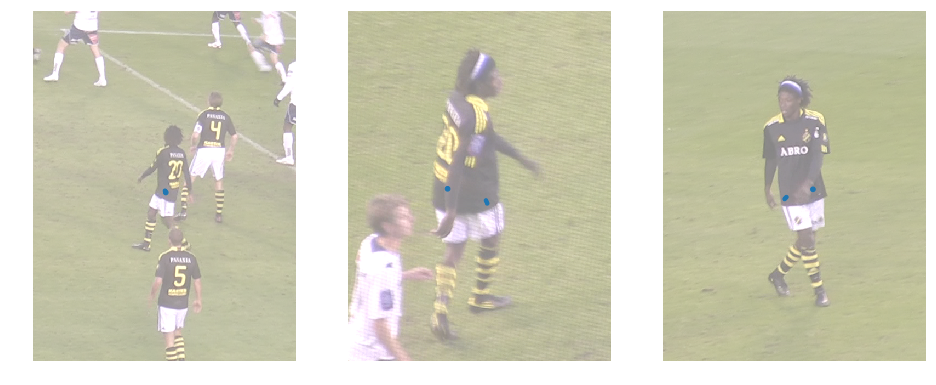

In [5]:
import mvpose.geometry.geometry as gm

JOINT = 11

pts3d_with_w = Debug.triangulation.peaks3d_weighted[JOINT]
pts3d = pts3d_with_w[:,0:3].astype('float32')


fig = plt.figure(figsize=(16,12))
for cid, (im, cam) in enumerate(zip(Im, Calib)):
    ax = fig.add_subplot(1,3, cid+1)
    ax.axis('off')
    ax.imshow(im, alpha=0.5)
    pts2d = cam.projectPoints_undist(pts3d)
    ax.scatter(pts2d[:,0], pts2d[:,1], 
               s=pts3d_with_w[:,3] * pts3d_with_w[:,4] * 50)
    
plt.show()

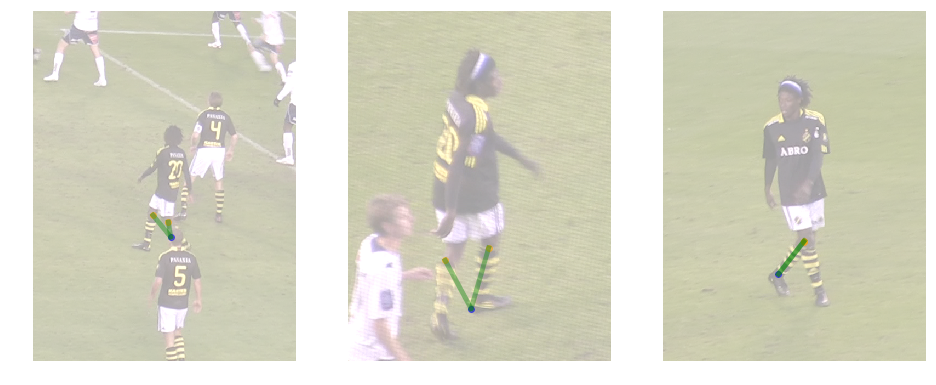

In [6]:
from mvpose.data.default_limbs import DEFAULT_LIMB_SEQ

LIMB_ID = 11
a,b = DEFAULT_LIMB_SEQ[LIMB_ID]

W = Debug.limbs3d[LIMB_ID]
n,m = W.shape
candA = Debug.triangulation.peaks3d_weighted[a][:,0:3]
candB = Debug.triangulation.peaks3d_weighted[b][:,0:3]
assert n == len(candA) and m == len(candB)

fig = plt.figure(figsize=(16,12))


for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    ptsA2d, maskA = cam.projectPoints(candA, withmask=True, binary_mask=False)
    ptsB2d, maskB = cam.projectPoints(candB, withmask=True, binary_mask=False)
    
    ax.scatter(ptsA2d[maskA][:,0], ptsA2d[maskA][:,1], color='orange', alpha=0.5)
    ax.scatter(ptsB2d[maskB][:,0], ptsB2d[maskB][:,1], color='blue', alpha=0.5)
    
    maskA = np.squeeze(maskA)
    if len(maskA.shape) == 0:
        maskA = np.expand_dims(maskA, axis=0)
    maskB = np.squeeze(maskB)
    if len(maskB.shape) == 0:
        maskB = np.expand_dims(maskB, axis=0)
    
    for _a in maskA:
        for _b in maskB:
            w = W[_a,_b]
            Ax,Ay = ptsA2d[_a]
            Bx,By = ptsB2d[_b]
            if w > 0:
                ax.plot([Ax,Bx], [Ay,By], color='green', linewidth=w*10, alpha=0.4)
            else:
                ax.plot([Ax,Bx], [Ay,By], color='red', linewidth=-w*10, alpha=0.4)

plt.show()

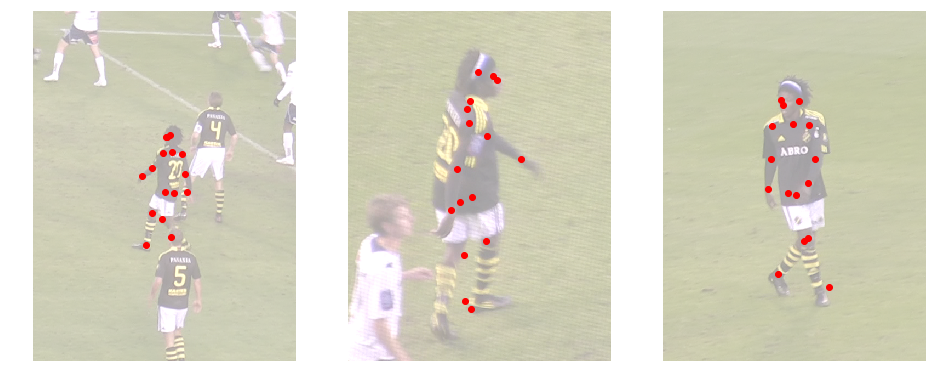

In [7]:
from mvpose.algorithm.candidate_selection import project_human_to_2d

Humans = detections

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(1,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.4)
    
    for pid, human in enumerate(Humans):
        human2d = project_human_to_2d(human, cam)
        for p in human2d:
            if p is not None:
                ax.scatter(p[0], p[1], color=colors[pid])
    
plt.show()